In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from utils.binary_ind import make_to_binary, modify_weights, apply_mask_binary

In [9]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted dimensions here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Adjusted dimensions here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [11]:
net = Net().to(device)
varianzas_net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10('./../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Realizamos el "entrenamiento"

In [14]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.95

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
individuo = make_to_binary(individuo)
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask_binary(net, individuo)

        masked_net.train()

        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask_binary(net, nuevo_individuo)

        masked_net.train()

        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        # Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)

        n_individuo += 1  

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.5564 Loss: 1.5353986832796764
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.5775 Loss: 1.47921198598869
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.5678 Loss: 1.4771880781101754
Nuevo mejor individuo
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.5809 Loss: 1.4886779720368593
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.5861 Loss: 1.5130547136449448
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.5779 Loss: 1.5586449084684366
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.572 Loss: 1.5532670695610973
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.555 Loss: 1.609341379245529
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.5589 Loss: 1.6048197042759118
 --------------------- Individuo 10 --------------------- 
Ac

KeyboardInterrupt: 

In [15]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))
index_max_accuracy = test_accuracies.index(max(test_accuracies))
print(index_max_accuracy)
print("-----------------")
print(min(train_loss))
index = train_loss.index(min(train_loss))
print(index)

[1.5353986832796764, 1.47921198598869, 1.4771880781101754, 1.4886779720368593, 1.5130547136449448, 1.5586449084684366, 1.5532670695610973, 1.609341379245529, 1.6048197042759118, 1.5836368704695836, 1.5754441560229377, 1.5864953636513341, 1.6306823043872023, 1.6269215115195954, 1.6965349052873109, 1.5766495040920385, 1.6727772628712227, 1.5895565741354851, 1.5781543526198247, 1.6420788839649971, 1.6590340748772292, 1.6571909545175254, 1.6298416041199812, 1.6334738374671058, 1.6138975441150958, 1.6390805770369137, 1.6316302863838117, 1.6287700926403865, 1.6165173407405844, 1.5801568840775648, 1.6652600208816626, 1.589361514886627, 1.5998146261095696, 1.609697013102529, 1.622661934255639, 1.632652526163994, 1.615962287501606, 1.6624128801743392, 1.6802614332769839, 1.6530618266681272, 1.6236466620584278, 1.6357540207750656, 1.5602318415099092, 1.6040605167903559, 1.6130510810238625, 1.647367466060097, 1.5842076351727976, 1.5965236355276669, 1.6267684155412951, 1.6098159864125654, 1.617277

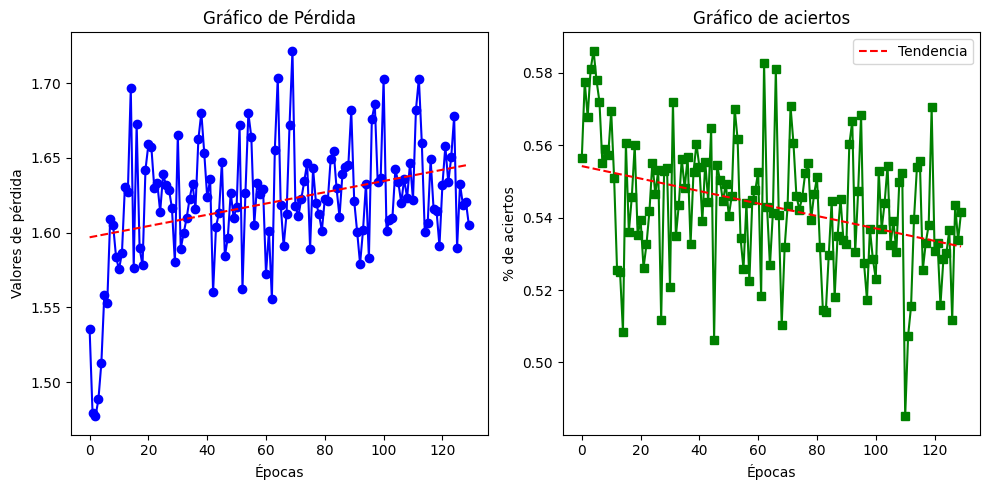

In [16]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Valores de pérdida")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("Épocas")
plt.ylabel("% de aciertos")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()